In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data
import tools

In [2]:
pro = ts.pro_api()

In [5]:
#获取行业分类
industrys = DP.get_all_industrys()

In [241]:
industry = ['801750.SI', '801740.SI', '801081.SI',]

#取行业内股票数据
data = DP.get_stock_daily_data(industrys=industrys,
                               industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'total_mv'])

money_dic = get_stock_money_data(industrys, industry)
for k in money_dic.keys():
    money_dic[k] = DataFrame(money_dic[k], index=data['open'].index, columns=data['open'].columns)

In [242]:
st = DP.get_st_data(industrys, industry, data['open'])

In [243]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

rzrqye = (money_dic['rzye'].fillna(method='ffill') - money_dic['rqye'].fillna(method='ffill')).fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
gt = money_dic['gt_vol'].fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
d_rzrq = rzrqye / rzrqye.shift()
d_rzrq.fillna(1, inplace=True)
d_gt = gt / gt.shift()
d_gt.fillna(1, inplace=True)

In [244]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [503]:
n = 2
y = standardize_industry(ror.rolling(n).sum().shift(-n+1) - r_geye, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [504]:
'''x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei.rolling(1).sumstandardize_industry().shift(1))
x3 = standardize_industry(r_rinei.rolling(3).sum().shift(2))
x4 = standardize_industry(r_rinei.rolling(5).sumstandardize_industry().shift(5))
x5 = standardize_industry(r_rinei.rolling(10).sumstandardize_industry().shift(10))

z1 = standardize_industry(r_geye)
z2 = standardize_industry(r_geye.rolling(1).sumstandardize_industry().shift(1))
z3 = standardize_industry(r_geye.rolling(3).sumstandardize_industry().shift(2))
z4 = standardize_industry(r_geye.rolling(5).sumstandardize_industry().shift(5))
z5 = standardize_industry(r_geye.rolling(10).sumstandardize_industry().shift(10))

m1 = standardize_industry(CLOSE/CLOSE.rolling(3).mean())
m2 = standardize_industry(CLOSE/CLOSE.rolling(5).mean())
m3 = standardize_industry(CLOSE/CLOSE.rolling(10).mean())
m4 = standardize_industry(CLOSE/CLOSE.rolling(20).mean())
m5 = standardize_industry(CLOSE/CLOSE.rolling(40).mean())

u1 = x1 - z1
u2 = x2 - z2
u3 = x3 - z3
u4 = x4 - z4
u5 = x5 - z5

r1 = x1 + z1
r2 = x2 + z2
r3 = x3 + z3
r4 = x4 + z4
r5 = x5 + z5

h1 = standardize_industry(rh)
h2 = standardize_industry(rh.rolling(1).sumstandardize_industry().shift(1))
h3 = standardize_industry(rh.rolling(3).sumstandardize_industry().shift(2))
h4 = standardize_industry(rh.rolling(5).sumstandardize_industry().shift(5))
h5 = standardize_industry(rh.rolling(10).sumstandardize_industry().shift(10))

l1 = standardize_industry(rl)
l2 = standardize_industry(rl.rolling(1).sumstandardize_industry().shift(1))
l3 = standardize_industry(rl.rolling(3).sumstandardize_industry().shift(2))
l4 = standardize_industry(rl.rolling(5).sumstandardize_industry().shift(5))
l5 = standardize_industry(rl.rolling(10).sumstandardize_industry().shift(10))

hl1 = h1 - l1
hl2 = h2 - l2
hl3 = h3 - l3
hl4 = h4 - l4
hl5 = h5 - l5

ch1 = x1 - h1
ch2 = x2 - h2
ch3 = x3 - h3
ch4 = x4 - h4
ch5 = x5 - h5

cl1 = x1 - l1
cl2 = x2 - l2
cl3 = x3 - l3
cl4 = x4 - l4
cl5 = x5 - l5


vr1 = standardize_industry(vr)
vr2 = standardize_industry(vr.rolling(1).sumstandardize_industry().shift(1))
vr3 = standardize_industry(vr.rolling(3).sumstandardize_industry().shift(2))
vr4 = standardize_industry(vr.rolling(5).sumstandardize_industry().shift(5))
vr5 = standardize_industry(vr.rolling(10).sumstandardize_industry().shift(10))


rzrq1 = standardize_industry(d_rzrq).fillna(0)
rzrq2 = standardize_industry(d_rzrq.rolling(1).sumstandardize_industry().shift(1)).fillna(0)
rzrq3 = standardize_industry(d_rzrq.rolling(3).sumstandardize_industry().shift(2)).fillna(0)
rzrq4 = standardize_industry(d_rzrq.rolling(5).sumstandardize_industry().shift(5)).fillna(0)
rzrq5 = standardize_industry(d_rzrq.rolling(10).sumstandardize_industry().shift(10)).fillna(0)

gt1 = standardize_industry(d_gt).fillna(0)
gt2 = standardize_industry(d_gt.rolling(1).sumstandardize_industry().shift(1)).fillna(0)
gt3 = standardize_industry(d_gt.rolling(3).sumstandardize_industry().shift(2)).fillna(0)
gt4 = standardize_industry(d_gt.rolling(5).sumstandardize_industry().shift(5)).fillna(0)
gt5 = standardize_industry(d_gt.rolling(10).sumstandardize_industry().shift(10)).fillna(0)

pe = standardize_industry(pe)
pb = standardize_industry(pb)
ps = standardize_industry(ps)

lmv = standardize_industry(lmv)
'''

'x1 = standardize_industry(r_rinei, industrys, industry)\nx2 = standardize_industry(r_rinei.rolling(1).sumstandardize_industry().shift(1))\nx3 = standardize_industry(r_rinei.rolling(3).sum().shift(2))\nx4 = standardize_industry(r_rinei.rolling(5).sumstandardize_industry().shift(5))\nx5 = standardize_industry(r_rinei.rolling(10).sumstandardize_industry().shift(10))\n\nz1 = standardize_industry(r_geye)\nz2 = standardize_industry(r_geye.rolling(1).sumstandardize_industry().shift(1))\nz3 = standardize_industry(r_geye.rolling(3).sumstandardize_industry().shift(2))\nz4 = standardize_industry(r_geye.rolling(5).sumstandardize_industry().shift(5))\nz5 = standardize_industry(r_geye.rolling(10).sumstandardize_industry().shift(10))\n\nm1 = standardize_industry(CLOSE/CLOSE.rolling(3).mean())\nm2 = standardize_industry(CLOSE/CLOSE.rolling(5).mean())\nm3 = standardize_industry(CLOSE/CLOSE.rolling(10).mean())\nm4 = standardize_industry(CLOSE/CLOSE.rolling(20).mean())\nm5 = standardize_industry(CLOSE/C

In [505]:
x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei.rolling(1).sum().shift(1), industrys, industry)
x3 = standardize_industry(r_rinei.rolling(3).sum().shift(2), industrys, industry)
x4 = standardize_industry(r_rinei.rolling(5).sum().shift(5), industrys, industry)
x5 = standardize_industry(r_rinei.rolling(10).sum().shift(10), industrys, industry)

z1 = standardize_industry(r_geye, industrys, industry)
z2 = standardize_industry(r_geye.rolling(1).sum().shift(1), industrys, industry)
z3 = standardize_industry(r_geye.rolling(3).sum().shift(2), industrys, industry)
z4 = standardize_industry(r_geye.rolling(5).sum().shift(5), industrys, industry)
z5 = standardize_industry(r_geye.rolling(10).sum().shift(10), industrys, industry)

m1 = standardize_industry(CLOSE/CLOSE.rolling(3).mean(), industrys, industry)
m2 = standardize_industry(CLOSE/CLOSE.rolling(5).mean(), industrys, industry)
m3 = standardize_industry(CLOSE/CLOSE.rolling(10).mean(), industrys, industry)
m4 = standardize_industry(CLOSE/CLOSE.rolling(20).mean(), industrys, industry)
m5 = standardize_industry(CLOSE/CLOSE.rolling(40).mean(), industrys, industry)

u1 = x1 - z1
u2 = x2 - z2
u3 = x3 - z3
u4 = x4 - z4
u5 = x5 - z5

r1 = x1 + z1
r2 = x2 + z2
r3 = x3 + z3
r4 = x4 + z4
r5 = x5 + z5

h1 = standardize_industry(rh, industrys, industry)
h2 = standardize_industry(rh.rolling(1).sum().shift(1), industrys, industry)
h3 = standardize_industry(rh.rolling(3).sum().shift(2), industrys, industry)
h4 = standardize_industry(rh.rolling(5).sum().shift(5), industrys, industry)
h5 = standardize_industry(rh.rolling(10).sum().shift(10), industrys, industry)

l1 = standardize_industry(rl, industrys, industry)
l2 = standardize_industry(rl.rolling(1).sum().shift(1), industrys, industry)
l3 = standardize_industry(rl.rolling(3).sum().shift(2), industrys, industry)
l4 = standardize_industry(rl.rolling(5).sum().shift(5), industrys, industry)
l5 = standardize_industry(rl.rolling(10).sum().shift(10), industrys, industry)

hl1 = h1 - l1
hl2 = h2 - l2
hl3 = h3 - l3
hl4 = h4 - l4
hl5 = h5 - l5

ch1 = x1 - h1
ch2 = x2 - h2
ch3 = x3 - h3
ch4 = x4 - h4
ch5 = x5 - h5

cl1 = x1 - l1
cl2 = x2 - l2
cl3 = x3 - l3
cl4 = x4 - l4
cl5 = x5 - l5


vr1 = standardize_industry(vr, industrys, industry)
vr2 = standardize_industry(vr.rolling(1).sum().shift(1), industrys, industry)
vr3 = standardize_industry(vr.rolling(3).sum().shift(2), industrys, industry)
vr4 = standardize_industry(vr.rolling(5).sum().shift(5), industrys, industry)
vr5 = standardize_industry(vr.rolling(10).sum().shift(10), industrys, industry)


rzrq1 = standardize_industry(d_rzrq, industrys, industry).fillna(0)
rzrq2 = standardize_industry(d_rzrq.rolling(1).sum().shift(1), industrys, industry).fillna(0)
rzrq3 = standardize_industry(d_rzrq.rolling(3).sum().shift(2), industrys, industry).fillna(0)
rzrq4 = standardize_industry(d_rzrq.rolling(5).sum().shift(5), industrys, industry).fillna(0)
rzrq5 = standardize_industry(d_rzrq.rolling(10).sum().shift(10), industrys, industry).fillna(0)

gt1 = standardize_industry(d_gt, industrys, industry).fillna(0)
gt2 = standardize_industry(d_gt.rolling(1).sum().shift(1), industrys, industry).fillna(0)
gt3 = standardize_industry(d_gt.rolling(3).sum().shift(2), industrys, industry).fillna(0)
gt4 = standardize_industry(d_gt.rolling(5).sum().shift(5), industrys, industry).fillna(0)
gt5 = standardize_industry(d_gt.rolling(10).sum().shift(10), industrys, industry).fillna(0)

pe = standardize_industry(pe, industrys, industry)
pb = standardize_industry(pb, industrys, industry)
ps = standardize_industry(ps, industrys, industry)

lmv = standardize_industry(lmv, industrys, industry)



In [506]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'u1':u1, 'u2':u2, 'u3':u3, 'u4':u4, 'u5':u5,#没啥用
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,#多余
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5,#估计没ch好用
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5,#同下
    'ch1':ch1, 'ch2':ch2, 'ch3':ch3, 'ch4':ch4, 'ch5':ch5,#试试看
    'cl1':cl1, 'cl2':cl2, 'cl3':cl3, 'cl4':cl4, 'cl5':cl5,#试试看
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5,#逻辑不好
    
    'm1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 'm5':m5,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5,
    'rzrq1':rzrq1, 'rzrq2':rzrq2, 'rzrq3':rzrq3, 'rzrq4':rzrq4, 'rzrq5':rzrq5,
    'gt1':gt1, 'gt2':gt2, 'gt3':gt3, 'gt4':gt4, 'gt5':gt5,
    'pe':pe, 'pb':pb, 'ps':ps,
    'lmv':lmv,
}

In [507]:
for k in factor.keys():
    df = DataFrame(factor[k])
    df[st] = 0
    #df[st] = DataFrame({stock:df.mean(1) for stock in df.columns})
    factor[k] = DataFrame(df)

In [508]:
#ic, ir = tools.icir(pe.shift(), y, n=60, rank=True)
#ir.plot()

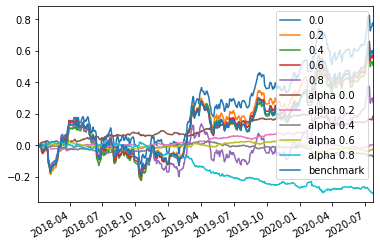

In [557]:
tools.group_backtest((x1).shift().iloc[-620:,:], ((ror.rolling(n).sum().shift(-n+1) - r_geye) / n).iloc[-620:,:], n=5)

In [594]:
begin_date = '2010-01-01'
split_date = '2020-06-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [595]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [596]:
model = smf.ols('y~x1\
                  +z1\
                  +r2+r3\
                  +h1\
                  +pe\
                  +lmv', data=df_train).fit()
model.tvalues

Intercept    -5.950584
x1          -26.780390
z1            2.945008
r2           -7.908138
r3          -19.673572
h1           21.255330
pe            7.993993
lmv         -17.157800
dtype: float64

002987.SZ    0.211246
002409.SZ    0.116162
300377.SZ    0.109932
300775.SZ    0.108556
300324.SZ    0.091589
603918.SH    0.089540
300368.SZ    0.086078
300525.SZ    0.078526
300552.SZ    0.074752
600667.SH    0.070381
Name: 2020-05-29 00:00:00, dtype: float64


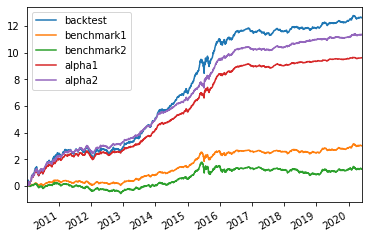

In [597]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_train).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 0.96
position = (y_hat.gt(y_hat.quantile(q, 1), 0)) & (y_hat.lt(y_hat.quantile(1, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

ror_huice = (position * (ror_train.rolling(m).sum().shift(-m+1) - r_geye_train) / m).mul(len(y.columns) / position.sum(1), 0)
ror_huice.mean(1).cumsum().plot()

benchmark1 = (ror_train.rolling(m).sum().shift(-m+1) - r_geye_train) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_train
benchmark2.mean(1).cumsum().plot()

alpha1 = ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()
alpha2 = ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()
alpha1.plot()
alpha2.plot()
#for i in industry:
#    stock = industrys[i]
#    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha1', 'alpha2'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [598]:
position.sum(1)

2010-01-04     0
2010-01-05     3
2010-01-06     2
2010-01-07     3
2010-01-08     3
              ..
2020-05-25    10
2020-05-26    10
2020-05-27    10
2020-05-28    10
2020-05-29    10
Length: 2528, dtype: int64

002177.SZ    0.160885
300782.SZ    0.100463
300561.SZ    0.099584
300608.SZ    0.084976
300556.SZ    0.081789
300155.SZ    0.076845
002153.SZ    0.073284
603516.SH    0.073099
300719.SZ    0.070291
002985.SZ    0.069822
Name: 2020-07-24 00:00:00, dtype: float64


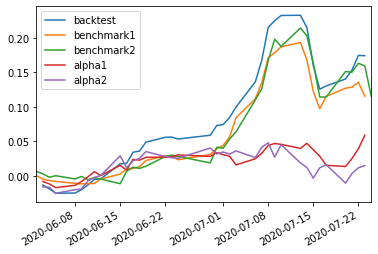

In [599]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q1 = 0.96
q2 = 1
position = (y_hat.gt(y_hat.quantile(q1, 1), 0)) & (y_hat.lt(y_hat.quantile(q2, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

ror_huice = (position * (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m).mul(len(y.columns) / position.sum(1), 0)
ror_huice.mean(1).cumsum().plot()

benchmark1 = (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_test
benchmark2.mean(1).cumsum().plot()

alpha1 = ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()
alpha2 = ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()
alpha1.plot()
alpha2.plot()
#for i in industry:
#    stock = industrys[i]
#    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha1', 'alpha2'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [600]:
position.sum(1)

2020-06-02     0
2020-06-03    10
2020-06-04    10
2020-06-05    10
2020-06-08    10
2020-06-09    10
2020-06-10    10
2020-06-11    10
2020-06-12    10
2020-06-15    10
2020-06-16    10
2020-06-17    10
2020-06-18    10
2020-06-19    10
2020-06-22    10
2020-06-23    10
2020-06-24    10
2020-06-29    10
2020-06-30    10
2020-07-01    10
2020-07-02    10
2020-07-03    10
2020-07-06    10
2020-07-07    10
2020-07-08    10
2020-07-09    10
2020-07-10    10
2020-07-13    10
2020-07-14    10
2020-07-15    10
2020-07-16    10
2020-07-17    10
2020-07-20    10
2020-07-21    10
2020-07-22    10
2020-07-23    10
2020-07-24    10
dtype: int64

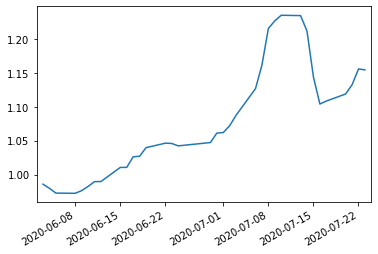

In [601]:
(ror_huice.mean(1)-0.0007+1).cumprod().plot()

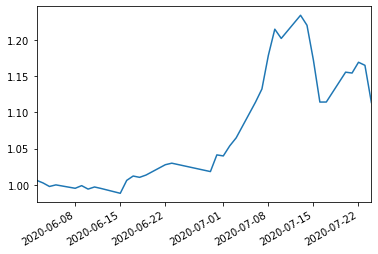

In [602]:
(benchmark2.mean(1)+1).cumprod().plot()

In [603]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300831.SZ    0.136725
300229.SZ    0.135339
300561.SZ    0.093531
603189.SH    0.092456
300719.SZ    0.092025
002987.SZ    0.091413
300659.SZ    0.089967
300448.SZ    0.082928
002401.SZ    0.082285
300462.SZ    0.075604
Name: 2020-07-24 00:00:00, dtype: float64


In [368]:
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [386]:
Series([1,2,3]).rename('1').name

'1'

In [387]:
factor = DataFrame(np.arange(12).reshape(3,4))

In [404]:
factor.apply(lambda a:Series(rankdata(a)), axis=1)

,0,1,2,3
0,4.0,1.0,2.0,3.0
1,1.0,2.0,3.0,4.0
2,1.0,2.0,3.0,4.0


In [390]:
factor.iloc[0,0] = 100

In [393]:
factor

,0,1,2,3
0,100,1,2,3
1,4,5,6,7
2,8,9,10,11


In [398]:
a=[200, 1,2,3]

In [399]:
sorted(range(len(a)), key = a.__getitem__)

[1, 2, 3, 0]

In [400]:
from scipy.stats import rankdata

In [401]:
rankdata(a)

array([4., 1., 2., 3.])

In [403]:
rankdata(factor)

array([12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [409]:
s = Series([1,2]).rename(11)

In [410]:
DataFrame(s)

,11
0,1
1,2
